In [33]:
from vizdoom import *
import random
import time
import numpy as np
from matplotlib import pyplot as plt
import os
from gym import Env
from gym.spaces import Discrete, Box
import cv2
import torch
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

In [3]:
game = DoomGame()
game.load_config('github/ViZDoom/scenarios/deadly_corridor.cfg')
game.init()

In [4]:
actions = np.identity(7, dtype=np.uint8)
actions

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [5]:
random.choice(actions)

array([0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [6]:
game.new_episode()

In [7]:
game.is_episode_finished()

False

In [93]:
game.make_action(random.choice(actions))

-1.0

In [96]:
game.make_action??
# second param is frame skip

Docstring:
make_action(*args, **kwargs)
Overloaded function.

1. make_action(self: vizdoom.vizdoom.DoomGame, arg0: object) -> float

2. make_action(self: vizdoom.vizdoom.DoomGame, arg0: object, arg1: int) -> float
Type:      method


In [6]:
episodes = 10
for episode in range(episodes):
    # Create new episode or game
    game.new_episode()
    # Checking game is not finished
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer # Current state game image
        info = state.game_variables
        reward = game.make_action(random.choice(actions))
        print('reward: ', reward)
        time.sleep(0.02)
    print('Result: ', game.get_total_reward())
    time.sleep(2)

reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  -0.78125
reward:  -0.7080078125
reward:  -0.641632080078125
reward:  -1.36273193359375
reward:  -1.2349853515625
reward:  -3.8618927001953125
reward:  -3.499847412109375
reward:  -2.3904876708984375
reward:  -1.45147705078125
reward:  0.0
reward:  0.0
reward:  -0.0432891845703125
reward:  -0.02301025390625
reward:  -0.0007476806640625
reward:  0.0
reward:  0.780853271484375
reward:  0.7076416015625
reward:  0.64129638671875
reward:  -0.19970703125
reward:  -0.2039947509765625
reward:  -0.18487548828125
reward:  -0.2135467529296875
reward:  -0.147552490234375
reward:  -0.0877532958984375
reward:  0.7001953125
reward:  0.6805267333984375
reward:  0.6167144775390625
reward:  1.3367462158203125
reward:  0.4335479736328125
reward:  -0.384979248046875
reward:  -0.3488922119140625
reward:  -0.316192626953125
reward:  -0.28656005859375
reward:  -0.25970458984375
reward:  -0.23536682

In [7]:
game.close()

# 1. Converting VizDoom to Gym Environment

In [132]:
Box(low=0, high=255, shape=(320, 240), dtype=np.uint8).sample()

array([[146, 156,  74, ..., 181,  87, 204],
       [149, 179,  16, ...,  93, 116,  41],
       [218,  38,  34, ...,  31, 255,  72],
       ...,
       [154,  44,  18, ...,  21,  10, 200],
       [165, 169, 100, ...,  36, 211, 122],
       [105,  82,  18, ...,  31,  82,  28]], dtype=uint8)

In [133]:
Discrete(7).sample()

1

In [118]:
actions[Discrete(7).sample()]

array([0, 0, 1], dtype=uint8)

In [36]:
# Create VizDoom OpenAi Gym Environment
class VizDoomGym(Env):
    def __init__(self, render=False, config='github/ViZDoom/scenarios/deadly_corridor.cfg'):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config(config)
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)
        if render:
            self.game.set_window_visible(True)
        else:
            self.game.set_window_visible(False)
        self.game.init()

        self.damage_taken = 0
        self.hit_count = 0
        self.selected_weapon_ammo = 52

    def step(self, action):
        actions = np.identity(7, dtype=np.uint8)
        movement_reward = self.game.make_action(actions[action], 4)

        reward = 0
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            # Reward Shaping
            health, damage_taken, hit_count, ammo = self.game.get_state().game_variables

            damage_taken_delta = self.damage_taken - damage_taken
            self.damage_taken = damage_taken
            hit_count_delta = hit_count - self.hit_count
            self.hit_count = hit_count
            ammo_delta = ammo - self.selected_weapon_ammo
            self.selected_weapon_ammo = ammo

            reward = movement_reward + damage_taken_delta*10 + hit_count_delta*200 + ammo_delta*5
        else:
            state = np.zeros(self.observation_space.shape)
            ammo = 0
        
        info = {"ammo": ammo}
        
        done = self.game.is_episode_finished()

        return state, reward, done, info

    def render():
        pass
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        self.damage_taken = 0
        self.hit_count = 0
        self.selected_weapon_ammo = 52
        
        return self.grayscale(state)

    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state

    def close(self):
        self.game.close()

In [23]:
env =  VizDoomGym(True)

In [24]:
state = env.reset()

In [25]:
env.step(0)

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 -40.0,
 False,
 {'ammo': 52.0})

In [187]:
env.observation_space.sample().shape

(3, 240, 320)

In [27]:
env.close()

In [214]:
state

array([[35, 39, 39, ..., 39, 39, 39],
       [59, 67, 59, ..., 67, 67, 91],
       [79, 79, 79, ..., 79, 91, 91],
       ...,
       [19, 19, 11, ..., 47, 47, 55],
       [19, 27, 19, ..., 47, 47, 47],
       [11, 19, 19, ..., 27, 19, 19]], dtype=uint8)

In [26]:
env = VizDoomGym(True)
env_checker.check_env(env)

# 2. View Game State

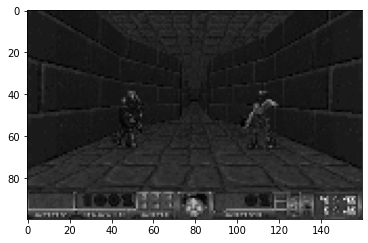

In [12]:
plt.imshow(state, cmap='gray')

# 3. Setup Callback

In [37]:
class TrainLogCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainLogCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [38]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'

In [39]:
callback = TrainLogCallback(10000, CHECKPOINT_DIR)

# 4. Train Model

In [41]:
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s1.cfg')
model = PPO(
    'CnnPolicy', 
    env, 
    tensorboard_log=LOG_DIR, 
    verbose=1, 
    learning_rate=0.0001,
    n_steps=8192,
    clip_range=0.1,
    gamma=0.95,
    gae_lambda=0.9
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [43]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_corridor\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 230      |
|    ep_rew_mean     | -591     |
| time/              |          |
|    fps             | 29       |
|    iterations      | 1        |
|    time_elapsed    | 278      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | -577         |
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 869          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0043559493 |
|    clip_fraction        | 0.227        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_varian

In [ ]:
#load trained model
#model.load('./train/train_corridor/$$$$$$$')

In [45]:
env = VizDoomGym('github/ViZDoom/scenarios/deadly_corridor_s2.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.5     |
|    ep_rew_mean     | -77.6    |
| time/              |          |
|    fps             | 34       |
|    iterations      | 1        |
|    time_elapsed    | 236      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49.9        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 753         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.040636297 |
|    clip_fraction        | 0.518       |
|

In [46]:
env = VizDoomGym('github/ViZDoom/scenarios/deadly_corridor_s3.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | 1.9e+03  |
| time/              |          |
|    fps             | 34       |
|    iterations      | 1        |
|    time_elapsed    | 237      |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 123        |
|    ep_rew_mean          | 1.9e+03    |
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 698        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.08818038 |
|    clip_fraction        | 0.429      |
|    clip_ran

In [47]:
env = VizDoomGym('github/ViZDoom/scenarios/deadly_corridor_s4.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 1.74e+03 |
| time/              |          |
|    fps             | 34       |
|    iterations      | 1        |
|    time_elapsed    | 237      |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 111        |
|    ep_rew_mean          | 1.78e+03   |
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 707        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.13081123 |
|    clip_fraction        | 0.282      |
|    clip_ran

In [48]:
env = VizDoomGym('github/ViZDoom/scenarios/deadly_corridor_s5.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_corridor\PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 182      |
|    ep_rew_mean     | 1.94e+03 |
| time/              |          |
|    fps             | 35       |
|    iterations      | 1        |
|    time_elapsed    | 232      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 161         |
|    ep_rew_mean          | 1.78e+03    |
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 700         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.115115605 |
|    clip_fraction        | 0.268       |
|

# 5. Test Model

In [30]:
## Continued at 1:46:05 while training
model = PPO.load('./train/train_basic/best_model_110000') ## Pass in model dir

In [39]:
env = VizDoomGym(render = True)

In [35]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

In [37]:
mean_reward

85.8

In [43]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.25)
        total_reward += reward
    print('Total reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

Total reward for episode 95.0 is 0
Total reward for episode 67.0 is 1
Total reward for episode 83.0 is 2
Total reward for episode 79.0 is 3
Total reward for episode 95.0 is 4


In [36]:
env.close()